## Sentiment Classification: classifying IMDB reviews

In this task, you will learn how to process text data and how to train neural networks with limited input text data using pre-trained embeddings for sentiment classification (classifying a review document as "positive" or "negative" based solely on the text content of the review).

We will use the `Embedding` layer in Keras to represent text input. The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, then looks up these integers into an internal dictionary, and finally returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have  shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer.

You can instantiate the `Embedding` layer by randomly initialising its weights (its internal dictionary of token vectors). During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for. You can also instantiate the `Embedding` layer by intialising its weights using the pre-trained word embeddings, such as GloVe word embeddings pretrained from Wikipedia articles.

#### a) Download the IMDB data as raw text

First, create a "data" directory, then head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Save it into the "data" directory. Uncompress it. Store the individual reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a separate `labels` list.

In [26]:
import os
import pandas as pd
from pathlib import Path
#NOTE: Assuming same directory structure as the one from the stanford link
TRAIN_DIR = "./aclImdb/train/"
TEST_DIR = "./aclImdb/test/"

#Use dataframes to store the parsed data
train = pd.DataFrame(data=None, columns=["text", "class"])
test = pd.DataFrame(data=None, columns=["text", "class"])

#For each pos/neg folder, read the review as a string, and add to the appropriate dataframe with the correct class label
for file in os.listdir(TRAIN_DIR+"pos"):
    text=Path(TRAIN_DIR+"pos/"+file).read_text()
    train = train.append({"text":text, "class": "positive"}, ignore_index=True)
    
for file in os.listdir(TRAIN_DIR+"neg"):
    text=Path(TRAIN_DIR+"neg/"+file).read_text()
    train = train.append({"text":text, "class": "negative"}, ignore_index=True)

for file in os.listdir(TEST_DIR+"pos"):
    text=Path(TEST_DIR+"pos/"+file).read_text()
    test = test.append({"text":text, "class": "positive"}, ignore_index=True)
    
for file in os.listdir(TEST_DIR+"neg"):
    text=Path(TEST_DIR+"neg/"+file).read_text()
    test = test.append({"text":text, "class": "negative"}, ignore_index=True)
    


#### b) Pre-process the review documents 

Pre-process review documents by tokenisation and split the data into the training and testing sets. You can restrict the training data to the first 1000 reviews and only consider the top 5,000 words in the dataset. You can also cut reviews after 100 words (that is, each review contains a maximum of 100 words).

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

POS_VALUE = 1
NEG_VALUE = 0

#Initialise the tokeniser with a max vocab size and fit it on the training data
VOCAB_SIZE = 5000
tokeniser = Tokenizer(num_words=VOCAB_SIZE)
tokeniser.fit_on_texts(train["text"])

#print(train)
#print(test)

train_data = train.copy()
test_data = test.copy()

#Take the first 500 positive and first 500 negative reviews as training data
train_data = train_data.head(500).append(train_data.tail(500))

#Convert the data into integer tokens
train_data["text"] = tokeniser.texts_to_sequences(train_data["text"])
#Use pad_sequences to pad/truncate the tokenised reviews and convert data to a list instead of a dataframe
x_train = pad_sequences(train_data["text"], 100, dtype="int32", padding="post", truncating="post", value=0)
#Convert the class labels to 0 or 1 and convert to a simple list again
train_data["class"] = train_data["class"].apply(lambda x: POS_VALUE if x == "positive" else NEG_VALUE)
y_train = train_data["class"].values

test_data["text"] = tokeniser.texts_to_sequences(test_data["text"])
x_test = pad_sequences(test_data["text"], maxlen=100, dtype="int32", padding="post", truncating="post", value=0)
test_data["class"] = test_data["class"].apply(lambda x: 1 if x == "positive" else 0)
y_test = test_data["class"].values

# write your code here

                                                    text     class
0      One of THE comedies of the 1970's. Also has th...  positive
1      This movie was excellent for the following rea...  positive
2      Wonderfully put together..I wish there was a f...  positive
3      Worry not, Disney fans--this special edition D...  positive
4      Of those comments here before mine, I mostly a...  positive
5      A few summer space campers actually were accid...  positive
6      This has got to be one of my very favorite Twi...  positive
7      This film is like an allegory of the gospel. I...  positive
8      The Bourne Ultimatum is the third and final ou...  positive
9      Until I saw this special on HBO, I had never h...  positive
10     A fine Martino outing, this is a spirited and ...  positive
11     whereas the hard-boiled detective stories of D...  positive
12     Gentleman Jim is another case of print the leg...  positive
13     I really like Star Trek Hidden Frontier it is ...  posi

#### c) Download the GloVe word embeddings and map each word in the dataset into its pre-trained GloVe word embedding.

First go to `https://nlp.stanford.edu/projects/glove/` and download the pre-trained 
embeddings from 2014 English Wikipedia into the "data" directory. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

Parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number vectors).

Build an embedding matrix that will be loaded into an `Embedding` layer later. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [36]:
# write your code here
import numpy as np

#Load and parse the glove embeddings into a dictionary
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

embedding_index = loadGloveModel("glove.6B.100d.txt")
#Initialise the embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE+1, 100))
#Trucate the tokeniser dictionary to only the first 5000 entries
tokeniser.word_index = dict(list(tokeniser.word_index.items())[:VOCAB_SIZE])

#Build the embedding matrix
for word, i in tokeniser.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



Loading Glove Model
Done. 400000  words loaded!


#### d) Build and train a simple Sequential model

The model contains an Embedding Layer with maximum number of tokens to be 10,000 and embedding dimensionality as 100. Initialise the Embedding Layer with the pre-trained GloVe word vectors. Set the maximum length of each review to 100. Flatten the 3D embedding output to 2D and add a Dense Layer which is the classifier. Train the model with a 'rmsprop' optimiser. You need to freeze the embedding layer by setting its `trainable` attribute to `False` so that its weights will not be updated during training.

In [37]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

#Sequential model with embedding layer, using the embedding matrix as the weights.
model = Sequential()
model.add(Embedding(VOCAB_SIZE+1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
#Flatted to 2D
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())
hist = model.fit(x_train, y_train, epochs=30, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          500100    
_________________________________________________________________
flatten_8 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 10001     
Total params: 510,101
Trainable params: 10,001
Non-trainable params: 500,100
_________________________________________________________________
None
Epoch 1/30
1000/1000 [==============================] - 1s 697us/step - loss: 0.9079 - acc: 0.5100
Epoch 2/30
1000/1000 [==============================] - 0s 31us/step - loss: 0.6102 - acc: 0.6610
Epoch 3/30
1000/1000 [==============================] - 0s 29us/step - loss: 0.4664 - acc: 0.7740
Epoch 4/30
1000/1000 [==============================] - 0s 31us/step - loss: 0.3986 - acc: 0.81

#### e) Plot the training and validation loss and accuracies and evaluate the trained model on the test set.

What do you observe from the results?

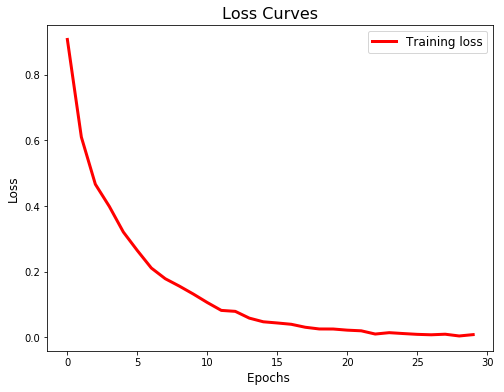

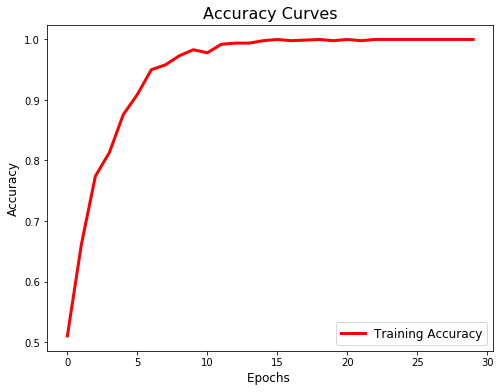

25000/25000 [==============================] - 1s 23us/step
Accuracy on test set: 60.156000
              precision    recall  f1-score   support

           0       0.60      0.62      0.61     12500
           1       0.61      0.58      0.59     12500

   micro avg       0.60      0.60      0.60     25000
   macro avg       0.60      0.60      0.60     25000
weighted avg       0.60      0.60      0.60     25000

[[7800 4700]
 [5261 7239]]


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

#Plot the loss curve on training data
plt.figure(figsize=[8,6])
plt.plot(hist.history['loss'],'r',linewidth=3.0)
#plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=16)
plt.show()

#Plot the accuracy curve on training data
plt.figure(figsize=[8,6])
plt.plot(hist.history['acc'],'r',linewidth=3.0)
#plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves',fontsize=16)
plt.show()


loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Accuracy on test set: %f' % (accuracy*100))

preds = model.predict_classes(x_test)
print (classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

# write your code here

#### f) Add an LSTM layer into the simple neural network architecture and re-train the model on the training set, plot the training and validation loss/accuracies, also evaluate the trained model on the test set and report the result.

In [42]:
from keras.layers import LSTM


model2 = Sequential()
model2.add(Embedding(VOCAB_SIZE+1, 100, weights=[embedding_matrix], input_length=100, trainable=False))
model2.add(LSTM(100))
#model2.add(Flatten())
model2.add(Dense(1, activation="sigmoid"))

model2.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
# write your code here
print(model2.summary())
hist2 = model2.fit(x_train, y_train, epochs=30, verbose=1)
# write your code here

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 100)          500100    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 580,601
Trainable params: 80,501
Non-trainable params: 500,100
_________________________________________________________________
None
Epoch 1/30
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6990 - acc: 0.5270
Epoch 2/30
1000/1000 [==============================] - 1s 943us/step - loss: 0.6750 - acc: 0.5660
Epoch 3/30
1000/1000 [==============================] - 1s 946us/step - loss: 0.6588 - acc: 0.6100
Epoch 4/30
1000/1000 [==============================] - 1s 941us/step - loss: 0.6574 - acc: 0.6

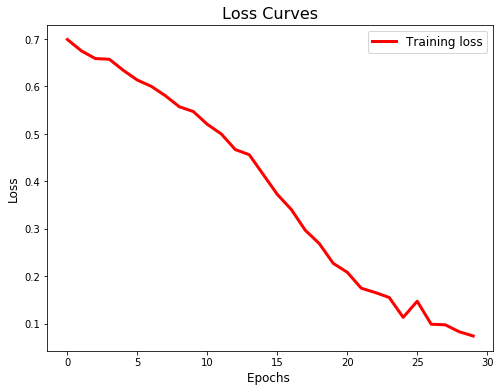

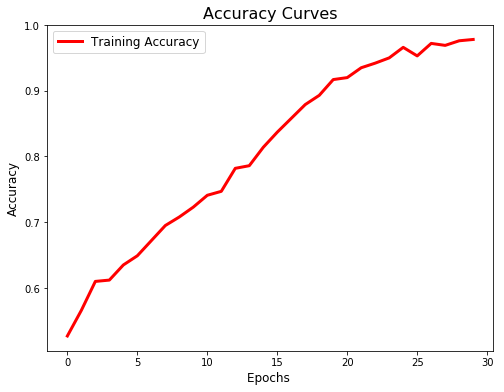

25000/25000 [==============================] - 6s 257us/step
Accuracy on test set: 65.156000


In [43]:
plt.figure(figsize=[8,6])
plt.plot(hist2.history['loss'],'r',linewidth=3.0)
#plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.title('Loss Curves',fontsize=16)
plt.show()

plt.figure(figsize=[8,6])
plt.plot(hist2.history['acc'],'r',linewidth=3.0)
#plt.plot(hist.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy'],fontsize=12)
plt.xlabel('Epochs ',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.title('Accuracy Curves',fontsize=16)
plt.show()


loss, accuracy = model2.evaluate(x_test, y_test, verbose=1)
print('Accuracy on test set: %f' % (accuracy*100))